In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

## Checking out charts

In [74]:
with open("the-graph.json") as graph_json:
    data = json.load(graph_json)

In [75]:
prices = data["prices"]

In [76]:
df = pd.DataFrame(prices, columns=["unix_ts", "price"])
df.dtypes

unix_ts      int64
price      float64
dtype: object

The timestamp arrives in milliseconds:

In [77]:
df["timestamp"] = pd.to_datetime(df["unix_ts"], unit='ms')

mindate = df["timestamp"].min().date()
maxdate = df["timestamp"].max().date()

print(f"Earliest Date: {mindate}")
print(f"Latest Date: {maxdate}")

Earliest Date: 2020-12-17
Latest Date: 2021-02-21


In [78]:
df.head()

,unix_ts,price,timestamp
0,1608163200000,0.120903,2020-12-17
1,1608249600000,0.120903,2020-12-18
2,1608336000000,0.261269,2020-12-19
3,1608422400000,0.482698,2020-12-20
4,1608508800000,0.749798,2020-12-21


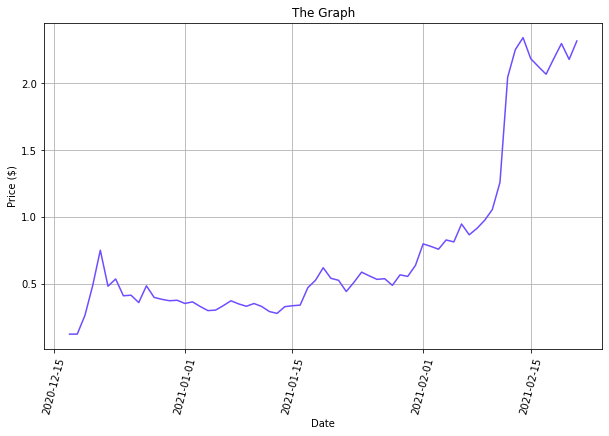

In [79]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df["timestamp"], df["price"], c="#6F4CFF")
ax.set(xlabel="Date", ylabel="Price ($)",
       title="The Graph")
ax.grid(b=True)

plt.xticks(rotation=75)
plt.show()

Will need to get prices for chosen intervals. For the sake of testing/demonstration, will use a seven day interval. I chose fridays somewhat arbitrarily as I tend not to pay attention to crypto as much on weekends.

In [80]:
earliest = df["timestamp"].min().date()
latest = df["timestamp"].max().date()

seven_days = pd.date_range(start=earliest, 
                           end=latest,
                           freq="W-FRI")
seven_days

DatetimeIndex(['2020-12-18', '2020-12-25', '2021-01-01', '2021-01-08',
               '2021-01-15', '2021-01-22', '2021-01-29', '2021-02-05',
               '2021-02-12', '2021-02-19'],
              dtype='datetime64[ns]', freq='W-FRI')

## Expected Value vs Straight Average

In [81]:
def closing_prices(data, dates):
    """gets the closing prices for the selected date range"""
    prices = []
    
    for date in dates:
        cond = data["timestamp"].dt.date == date
        max_date = data.loc[cond]["timestamp"].max()
        prices.append(data.loc[data["timestamp"] == max_date]["price"].values[0])
        
    return prices
        
prices = closing_prices(df, seven_days)

In [82]:
prices

[0.12090320886073201,
 0.41261777614343237,
 0.35083089348560426,
 0.34747863219571423,
 0.3337795884479543,
 0.44031433975373463,
 0.5652879317430903,
 0.8121773828746445,
 2.046628946749041,
 2.2995654386337403]

In [83]:
def get_growths(prices):
    """gets changes in price from one price to another"""
    changes = []
    
    for i in range(len(prices)-1):
        growth = (prices[i+1] - prices[i]) / prices[i]
        changes.append(growth)
        
    return changes

prices = get_growths(prices)
prices

[2.4127942511329485,
 -0.14974362771115812,
 -0.009555205519629012,
 -0.03942413281989687,
 0.3191769508769471,
 0.2838281216533914,
 0.43674990614121123,
 1.5199285154988462,
 0.12358688285264172]

The question here is: will expected value boil down to just an average if the change values are all distinct?

In [84]:
# get expected value

values = {}

for change in changes:
    if change not in values:
        values[change] = 1
    else:
        values[change] += 1
        
values

{0.4835569988724006: 1,
 -0.0423795489846256: 1,
 -0.06157342768379791: 1,
 0.01482681474437242: 1,
 0.47269784431614037: 1,
 0.1221701520166417: 1,
 0.6755440321147647: 1,
 1.468527638947589: 1}

In [85]:
# expected value
def ev(value_set):
    expected_value = 0
    for value, count in value_set.items():
        expected_value += value * (count / len(value_set))
        
    return expected_value

# average
def avg(price_changes):
    return sum(price_changes) / len(price_changes)

ex_val = ev(values)
average = avg(changes)

print(f"Expected Value: {ex_val}")
print(f"Average: {average}")

Expected Value: 0.3916713130429357
Average: 0.3916713130429357


The expected value is exactly the same as the average because it boils down to the same process. There is no generalization happening. I suspect that rounding could help, but until we have more data, we won't get the intended effect of expected value, which is weighted depending on probability. What happens if we use rounding to get closer to a generalization and extract a more detailed set of data?

In [86]:
# get more data using a finer granularity

daily = pd.date_range(start=earliest, end=latest)

daily_prices = closing_prices(df, daily)
daily_changes = get_growths(daily_prices)

def count_and_round(changes):
    counts = {}
    for change in changes:
        # change = round(change, 2)
        
        if change not in counts:
            counts[change] = 1
        else:
            counts[change] += 1
    
    return counts

# in order to make a proper comparison, we
# need to round within the average function

def avg(price_changes):
    price_changes = list(map(lambda x: round(x, 2), price_changes))
    
    return sum(price_changes) / len(price_changes)

change_count = count_and_round(daily_changes)

xv = ev(change_count)
av = avg(daily_changes)

print(f"Expected Value: {xv}")
print(f"Average: {av}")
print(f"Difference: {abs(xv - av)}")

Expected Value: 0.0656362556874847
Average: 0.06515151515151511
Difference: 0.00048474053596958555


## REN: Using a larger dataset
Does this change much when you look at a larger set of data? REN has a wider history:

In [87]:
with open("republic-protocol.json", "r") as ren_file:
    ren_json = json.load(ren_file)
    
ren_prices = ren_json["prices"]

ren_df = pd.DataFrame(data=ren_prices, columns=["unix_ts", "price"])
ren_df["timestamp"] = pd.to_datetime(ren_df["unix_ts"], unit="ms")

ren_df.head()

,unix_ts,price,timestamp
0,1575244800000,0.038661,2019-12-02
1,1575331200000,0.037787,2019-12-03
2,1575417600000,0.038969,2019-12-04
3,1575504000000,0.035245,2019-12-05
4,1575590400000,0.037915,2019-12-06


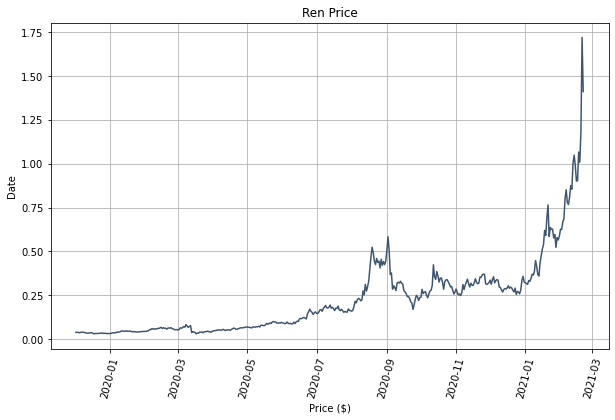

In [88]:
# plot REN history for fun
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ren_df["timestamp"], ren_df["price"], c="#3F566F")
ax.set(xlabel="Price ($)", ylabel="Date", title="Ren Price")
ax.grid(b=True)

plt.xticks(rotation=75)

plt.show()

### Weekly vs Daily Holds
EV vs Average:

In [93]:
# create a re-usable function

def hold_values(price_data, frequency="D"):
    earliest = price_data["timestamp"].min().date()
    latest = price_data["timestamp"].max().date()

    drange = pd.date_range(start=earliest, end=latest, freq=frequency)
    
    prices = closing_prices(price_data, drange)
    price_changes = get_growths(prices)
    change_counts = count_and_round(price_changes)
    
    average = avg(price_changes)
    expected_value = ev(change_counts)
    difference = abs(average - expected_value)
    
    return average, expected_value, difference

ren_result = hold_values(ren_df, frequency="W-FRI")
print(ren_result)

(0.07365079365079365, 0.07355732158592021, 9.347206487343718e-05)


In [95]:
ren_daily = hold_values(ren_df)
print("REN Daily:", ren_daily)

ren_monthly = hold_values(ren_df, frequency="M")
print("REN Monthly:", ren_monthly)

REN Daily: (0.011901565995525732, 0.011811863036828062, 8.970295869767039e-05)
REN Monthly: (0.3438461538461539, 0.3439575270846264, 0.0001113732384724897)


Trying to calculate the expected value results in almost the same value as the average. The difference is minor enough to not make a difference. In order to really make a difference, my assumption is that there would have to be quite a limited variation in growth outcomes for a given hold period.